<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/pinn_neural_ode_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
!pip install torchdiffeq

In [6]:
from google.colab import files
uploaded = files.upload()

Saving arabido_example_genes (1).csv to arabido_example_genes (1).csv


Epoch    0 | Loss: 0.2930 (Data: 0.2858, Physics: 0.0724)
Epoch   50 | Loss: 0.2112 (Data: 0.2107, Physics: 0.0056)
Epoch  100 | Loss: 0.1635 (Data: 0.1635, Physics: 0.0005)
Epoch  150 | Loss: 0.1202 (Data: 0.1201, Physics: 0.0011)
Epoch  200 | Loss: 0.0703 (Data: 0.0701, Physics: 0.0022)
Epoch  250 | Loss: 0.0304 (Data: 0.0301, Physics: 0.0029)
Epoch  300 | Loss: 0.0088 (Data: 0.0088, Physics: 0.0001)


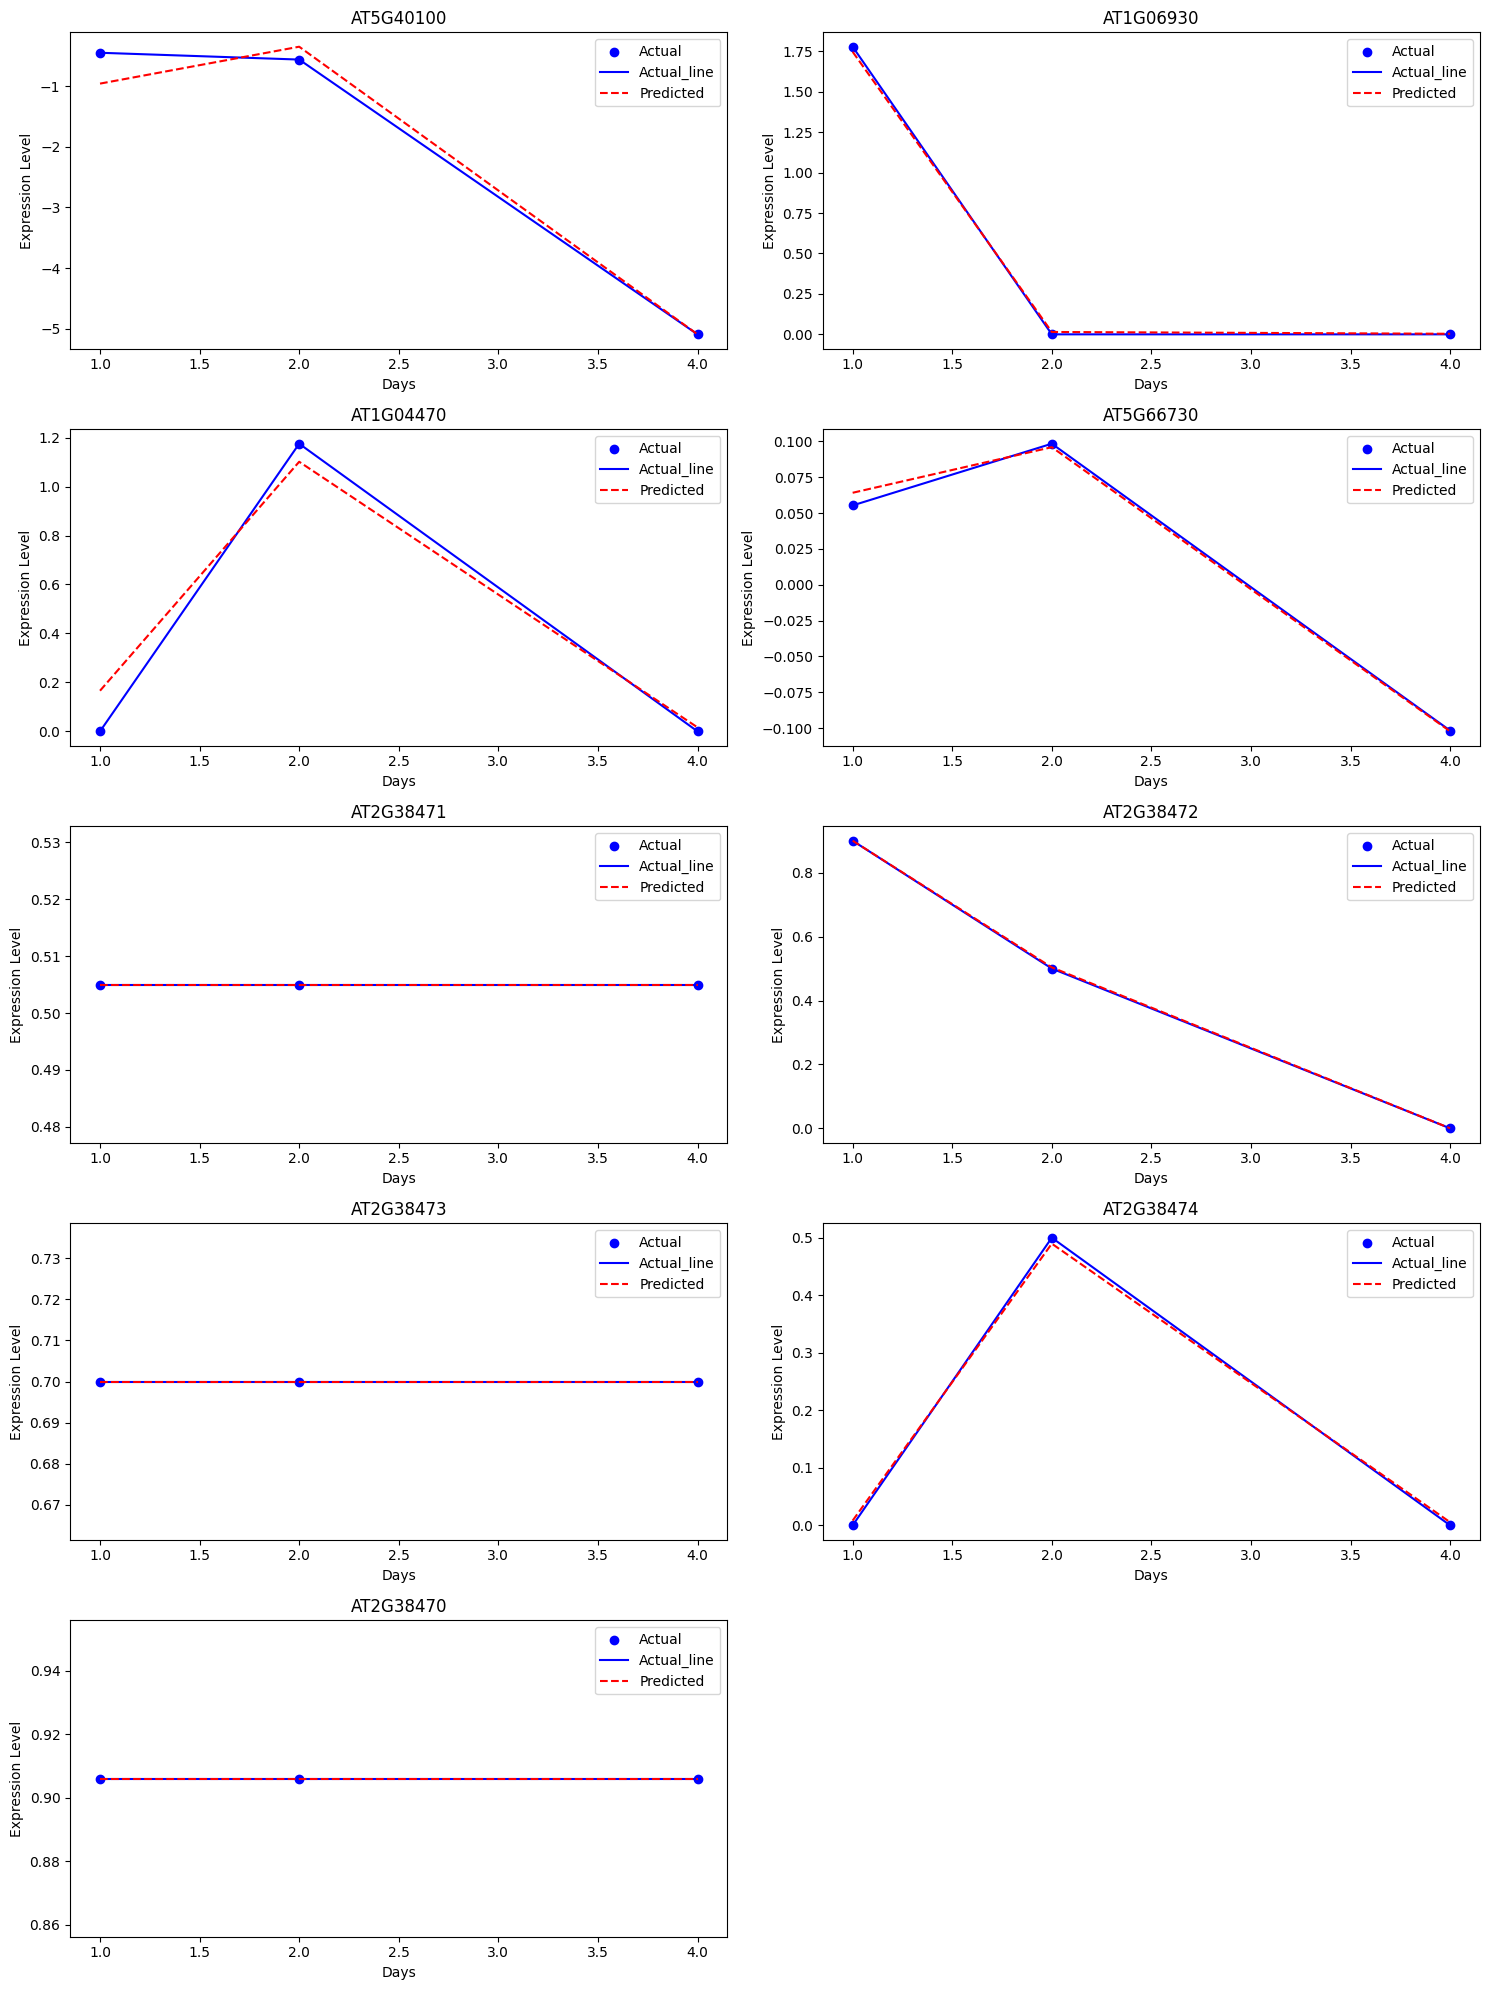


ODE Equations:

dAT5G40100/dt = -4.8767e-02·AT5G40100 + -9.5956e-03·AT1G06930 + -2.6537e-02·AT1G04470 + -1.6309e-02·AT5G66730 + -3.5796e-02·AT2G38471 + -3.8217e-02·AT2G38472 + -3.7391e-02·AT2G38473 + -1.0428e-02·AT2G38474 + -1.0079e-02·AT2G38470 + -1.7049e-02

dAT1G06930/dt = -1.2736e-01·AT5G40100 + -1.4711e-02·AT1G06930 + -7.3831e-02·AT1G04470 + -4.9971e-02·AT5G66730 + -8.9300e-02·AT2G38471 + -1.0237e-01·AT2G38472 + -8.7918e-02·AT2G38473 + -1.2792e-02·AT2G38474 + -1.0632e-02·AT2G38470 + -4.5639e-02

dAT1G04470/dt = -1.8587e-01·AT5G40100 + -3.6611e-02·AT1G06930 + -1.1638e-01·AT1G04470 + -6.4802e-02·AT5G66730 + -1.4937e-01·AT2G38471 + -1.5677e-01·AT2G38472 + -1.4915e-01·AT2G38473 + -3.4047e-02·AT2G38474 + -3.1173e-02·AT2G38470 + -6.7147e-02

dAT5G66730/dt = -1.0855e+00·AT5G40100 + -1.8086e-01·AT1G06930 + -6.6210e-01·AT1G04470 + -3.9992e-01·AT5G66730 + -8.5653e-01·AT2G38471 + -9.3728e-01·AT2G38472 + -7.9622e-01·AT2G38473 + -1.8685e-01·AT2G38474 + -1.6670e-01·AT2G38470 + -4.0277e-01

AT2

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('arabido_example_genes (1).csv', index_col=0)
gene_ids = df.index.tolist()
time_points_np = np.array([1.0, 2.0, 4.0])
expression_data_np = df.values.astype(np.float32)

# Handle constant genes (prevent division by zero)
epsilon = 1e-8
gene_ranges = expression_data_np.max(axis=1) - expression_data_np.min(axis=1)
constant_genes = np.where(gene_ranges < epsilon)[0]
gene_ranges[constant_genes] = 1.0  # Avoid division by zero

# Normalization
gene_min = expression_data_np.min(axis=1, keepdims=True)
gene_max = expression_data_np.max(axis=1, keepdims=True)
normalized_data = (expression_data_np - gene_min) / (gene_max - gene_min + epsilon)

# Convert to tensors with requires_grad=True for time_points
time_points = torch.tensor(time_points_np, dtype=torch.float32, requires_grad=True).unsqueeze(-1)
normalized_tensor = torch.tensor(normalized_data.T, dtype=torch.float32)

# Model parameters
n_genes = len(gene_ids)
input_size = 1
hidden_size = 16  # Reduced complexity
ode_params_per_gene = n_genes + 1

class ImprovedGeneModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_genes)
        self.theta = nn.Parameter(torch.randn(n_genes, ode_params_per_gene) * 0.01)  # Smaller initialization

    def forward(self, t):
        out, _ = self.lstm(t)
        return self.fc(out)

model = ImprovedGeneModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added regularization
epochs = 350
lambda_physics = 0.1  # Adjusted balance

# Training loop with gradient clipping
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    t_sequence = time_points.unsqueeze(0)  # Add batch dimension
    preds = model(t_sequence).squeeze(0)

    # Data loss
    data_loss = torch.mean((preds - normalized_tensor) ** 2)

# Physics loss
    dy_dt = torch.autograd.grad(
        outputs=preds,
        inputs=time_points,
        grad_outputs=torch.ones_like(preds),
        create_graph=True,
        retain_graph=True
    )[0]

    physics_loss = 0
    for i in range(n_genes):
        # Only consider non-constant genes in ODE
        if i not in constant_genes:
            interactions = torch.mm(model.theta[i, :-1].unsqueeze(0), preds.T)
            ode_rhs = interactions + model.theta[i, -1]
            # The error is due to dy_dt having shape (3, 1)
            # Instead of dy_dt[:, i], we should use dy_dt[:, 0]
            # to get the gradient for all time points.
            physics_loss += torch.mean((dy_dt[:, 0] - ode_rhs.squeeze(0)) ** 2)

            #physics_loss += torch.mean((dy_dt[:, i] - ode_rhs) ** 2)  # Correct indexing

    total_loss = data_loss + lambda_physics * physics_loss
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch:4d} | Loss: {total_loss.item():.4f} '
              f'(Data: {data_loss.item():.4f}, Physics: {physics_loss.item():.4f})')

# Generate predictions
with torch.no_grad():
    t_sequence = time_points.unsqueeze(0)
    preds_normalized = model(t_sequence).squeeze(0).numpy().T

# Inverse normalization
preds_original = preds_normalized * (gene_max - gene_min) + gene_min


# Plotting
plt.figure(figsize=(15, 20))
for i, gene_id in enumerate(gene_ids):
    plt.subplot(5, 2, i+1)
    plt.scatter(time_points_np, expression_data_np[i], c='b', label='Actual')
    plt.plot(time_points_np, expression_data_np[i], c='b', label='Actual_line')
    plt.plot(time_points_np, preds_original[i], 'r--', label='Predicted')
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression Level')
    plt.legend()
plt.tight_layout()
plt.show()



# Print parameters
theta_estimated = model.theta.detach().numpy()
scaling_factors = (gene_max - gene_min + epsilon).T

print("\nODE Equations:")
for i, gene_id in enumerate(gene_ids):
    if i in constant_genes:
        print(f"\n{gene_id}: Constant expression (no ODE)")
        continue

    # Reshape scaling_factors to be compatible with theta_estimated
    # by repeating it along a new dimension
    # Use scaling_factors[0] to index the first row (gene)
    # and then repeat it for the number of ODE parameters (10)
    # The resulting shape will be (10,)
    repeated_scaling_factors = np.repeat(scaling_factors[0][i], ode_params_per_gene)

    # Now, params will have the correct shape for element-wise division
    params = theta_estimated[i] / repeated_scaling_factors
    equation = f"d{gene_id}/dt = "
    for j in range(n_genes):
        equation += f"{params[j]:.4e}·{gene_ids[j]} + "
    equation += f"{params[-1]:.4e}"
    print(f"\n{equation}")

Epoch    0 | Loss: 0.6022 (Data: 0.6022, Physics: 0.0000)
Epoch   50 | Loss: 0.0113 (Data: 0.0113, Physics: 0.0000)
Epoch  100 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)
Epoch  150 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)
Epoch  200 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)
Epoch  250 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)


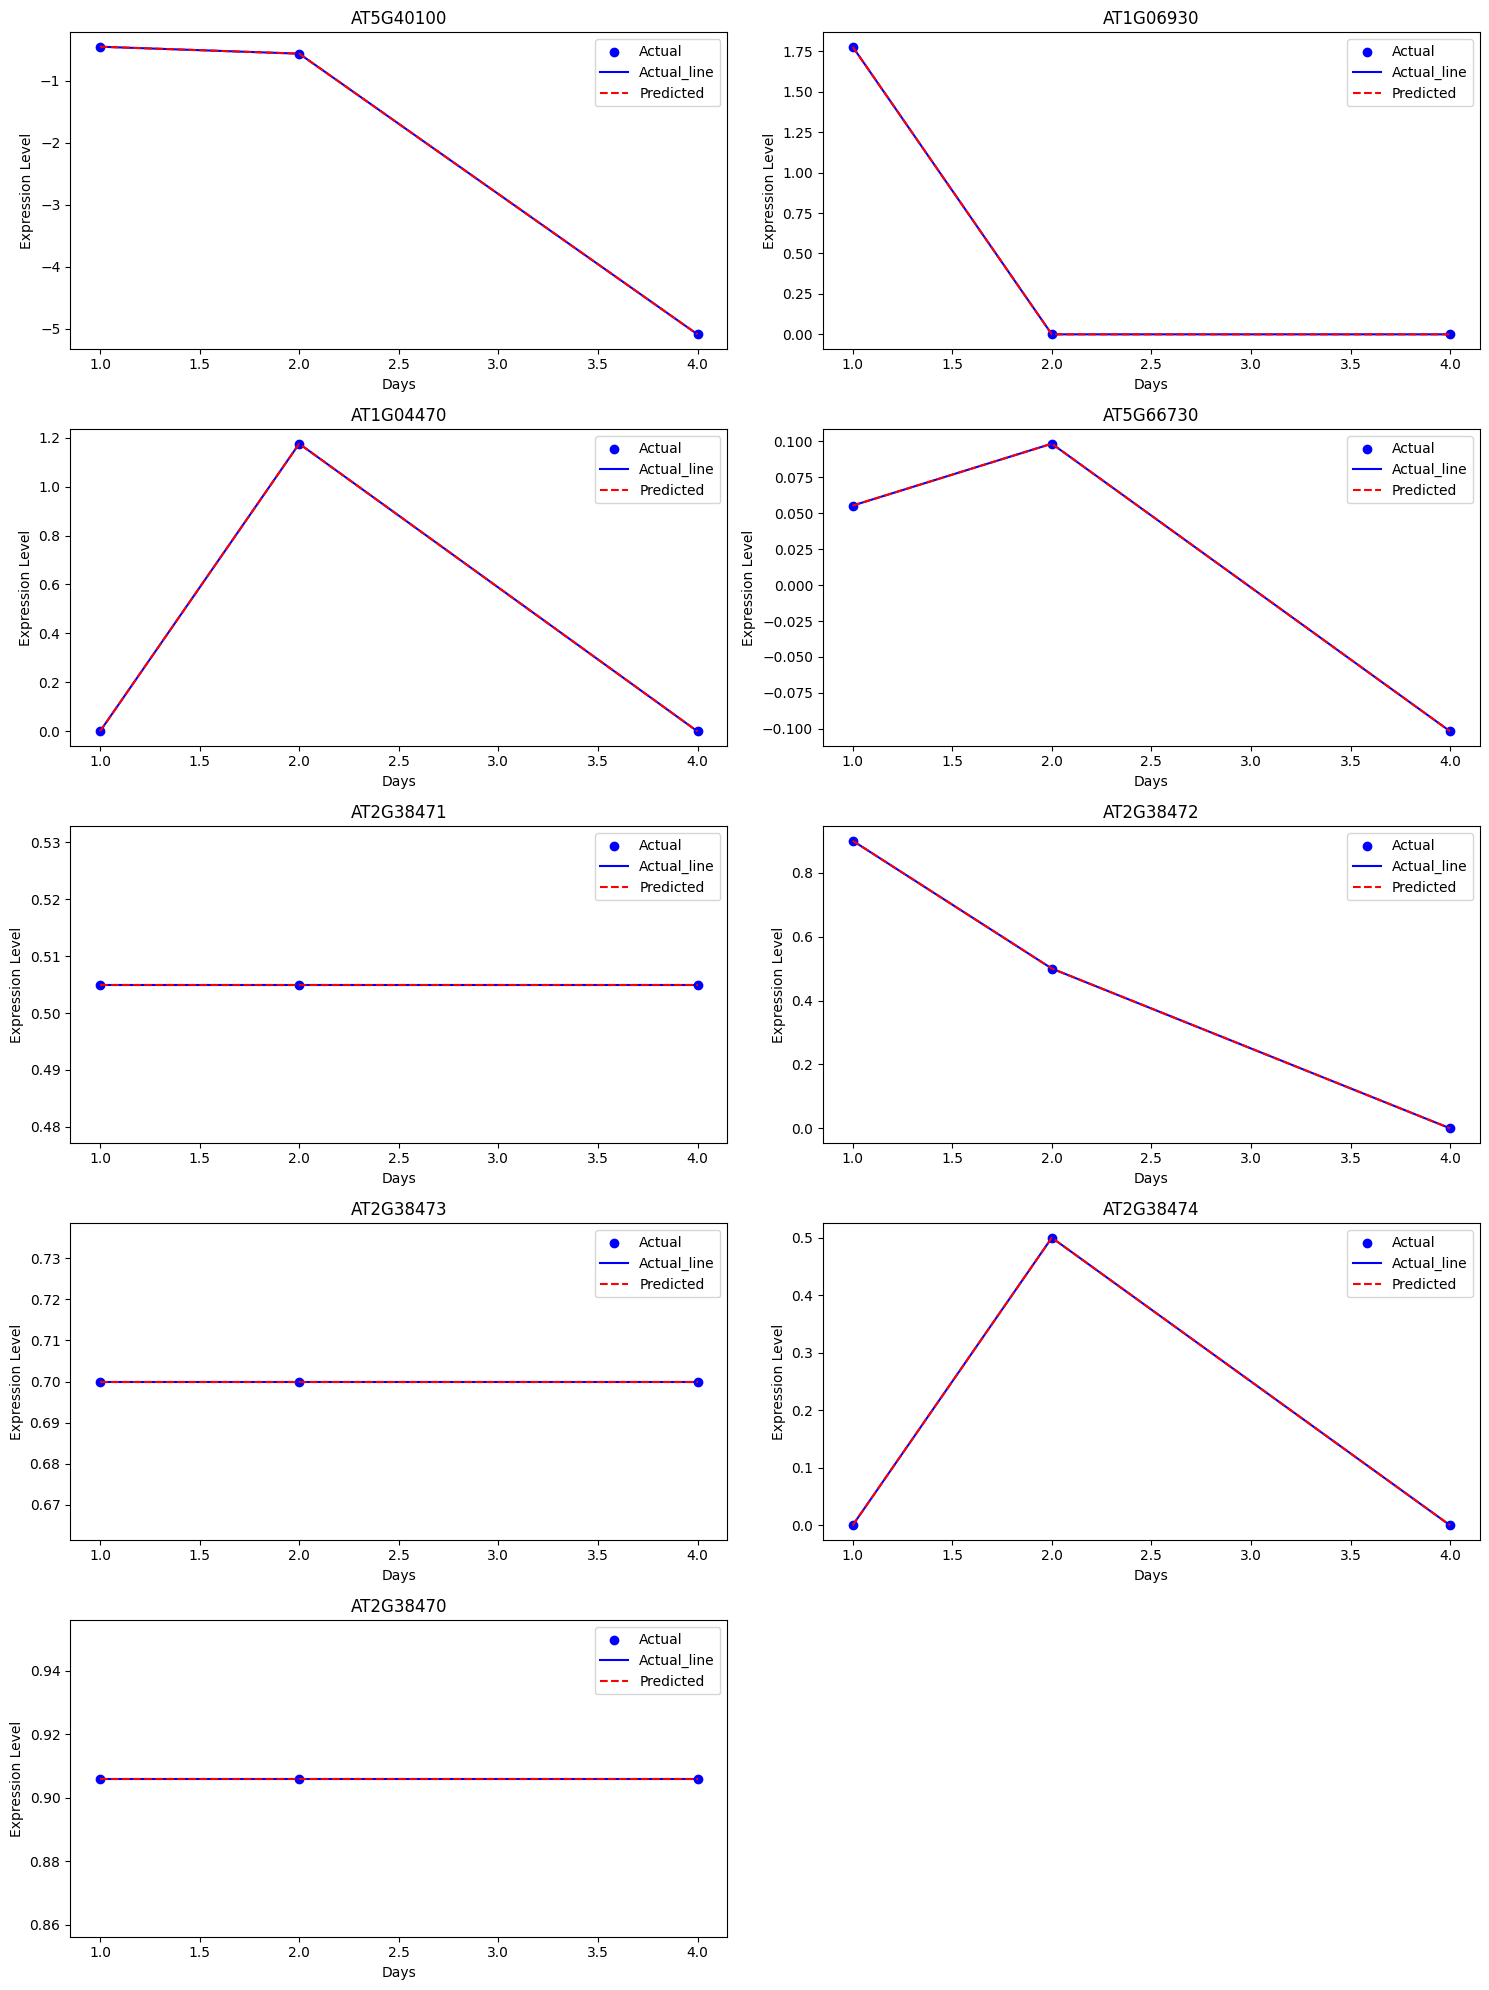


Learned ODE Parameters:
net.0.weight:
tensor([[-0.2073, -0.3310,  0.2273,  0.2501, -0.1414,  0.3054,  0.0188,  0.5427,
         -0.2056],
        [ 0.2082,  0.2085,  0.0675,  0.1856, -0.3411,  0.2301,  0.3462, -0.3829,
          0.2795],
        [ 0.1722, -0.0383, -0.4671,  0.2003,  0.1478,  0.2020, -0.1610, -0.2159,
          0.5962],
        [ 0.0519,  0.1761, -0.3918,  0.1957, -0.0406,  0.2473, -0.2546, -0.0255,
          0.1564],
        [-0.3008, -0.1615,  0.0832, -0.5116,  0.4000, -0.2030, -0.3843,  0.4114,
         -0.4638],
        [ 0.2625,  0.4986,  0.0244, -0.0459, -0.1516, -0.2499,  0.3347, -0.4440,
          0.6014],
        [ 0.0532,  0.4562, -0.5621,  0.4401,  0.0984,  0.4237, -0.0091, -0.2285,
          0.6270],
        [-0.1258, -0.2271, -0.0586, -0.0593, -0.3470, -0.2930,  0.2102,  0.3036,
         -0.1743],
        [-0.1952,  0.0088,  0.0762,  0.2255, -0.3086,  0.0891, -0.2161, -0.1417,
         -0.2636],
        [-0.0646, -0.0058, -0.0338, -0.2832,  0.2337,  0.1795

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # For ODE solving

# Load and preprocess data
df = pd.read_csv('arabido_example_genes (1).csv', index_col=0)
gene_ids = df.index.tolist()
time_points_np = np.array([1.0, 2.0, 4.0])
expression_data_np = df.values.astype(np.float32)

# Handle constant genes (prevent division by zero)
epsilon = 1e-8
gene_ranges = expression_data_np.max(axis=1) - expression_data_np.min(axis=1)
constant_genes = np.where(gene_ranges < epsilon)[0]
gene_ranges[constant_genes] = 1.0  # Avoid division by zero

# Normalization
gene_min = expression_data_np.min(axis=1, keepdims=True)
gene_max = expression_data_np.max(axis=1, keepdims=True)
normalized_data = (expression_data_np - gene_min) / (gene_max - gene_min + epsilon)

# Convert to tensors
time_points = torch.tensor(time_points_np, dtype=torch.float32)
normalized_tensor = torch.tensor(normalized_data.T, dtype=torch.float32)

# Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self, n_genes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_genes, 16),
            nn.Tanh(),
            nn.Linear(16, n_genes)
        )
        self.n_genes = n_genes

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, t, y0):
        return odeint(self.odefunc, y0, t, method='dopri5')  # Use an ODE solver

# Initialize model
n_genes = len(gene_ids)
odefunc = ODEFunc(n_genes)
model = NeuralODEModel(odefunc)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 300
lambda_physics = 0.1

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Initial condition (normalized expression at t=0)
    y0 = normalized_tensor[0]  # Use the first time point as the initial condition

    # Forward pass (solve ODE)
    preds = model(time_points, y0)

    # Data loss (compare predictions with actual data)
    data_loss = torch.mean((preds - normalized_tensor) ** 2)

# ... (rest of the code)

    physics_loss = 0
    for i in range(n_genes):
        if i not in constant_genes:
            # Compute the derivative from the ODE function
            dy_dt = odefunc(time_points, preds)[:, i]

            # ***CHANGE***: Correctly calculate ode_rhs using the network
            ode_rhs = odefunc(time_points, preds)[:, i]  # Use the network's output directly

            physics_loss += torch.mean((dy_dt - ode_rhs.squeeze()) ** 2)


# ... (rest of the code)

    total_loss = data_loss + lambda_physics * physics_loss
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch:4d} | Loss: {total_loss.item():.4f} '
              f'(Data: {data_loss.item():.4f}, Physics: {physics_loss.item():.4f})')

# Generate predictions
with torch.no_grad():
    y0 = normalized_tensor[0]
    preds_normalized = model(time_points, y0).numpy().T

# Inverse normalization
preds_original = preds_normalized * (gene_max - gene_min) + gene_min

# Plotting
plt.figure(figsize=(15, 20))
for i, gene_id in enumerate(gene_ids):
    plt.subplot(5, 2, i+1)
    plt.scatter(time_points_np, expression_data_np[i], c='b', label='Actual')
    plt.plot(time_points_np, expression_data_np[i], c='b', label='Actual_line')
    plt.plot(time_points_np, preds_original[i], 'r--', label='Predicted')
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression Level')
    plt.legend()
plt.tight_layout()
plt.show()

# After training, print the ODE parameters
print("\nLearned ODE Parameters:")
for name, param in odefunc.named_parameters():
    if param.requires_grad:
        print(f"{name}:")
        print(param.data)

# Print ODE equations
print("\nODE Equations:")
for i, gene_id in enumerate(gene_ids):
    if i in constant_genes:
        print(f"\n{gene_id}: Constant expression (no ODE)")
        continue

    # Get the weights and bias for this gene
    weights = odefunc.net[2].weight[i].detach().numpy()
    bias = odefunc.net[2].bias[i].item()

    # Write the ODE equation
    equation = f"d{gene_id}/dt = "
    for j in range(n_genes):
        equation += f"{weights[j]:.4f}·{gene_ids[j]} + "
    equation += f"{bias:.4f}"
    print(f"\n{equation}")

In [24]:
# Generate synthetic data using the learned ODEs
def generate_synthetic_data(odefunc, initial_conditions, time_points):
    with torch.no_grad():
        synthetic_data = odeint(odefunc, initial_conditions, time_points, method='dopri5')
    return synthetic_data.numpy()

# Initial conditions for synthetic data generation
initial_conditions = torch.tensor(normalized_data[:, 0], dtype=torch.float32)

# Generate synthetic data
synthetic_data = generate_synthetic_data(odefunc, initial_conditions, time_points)



In [25]:
df


,Hpa-NO_1d,Hpa-NO_2d,Hpa-NO_4d
AT5G40100,-0.447960,-0.560155,-5.091964
AT1G06930,1.778359,0.000000,0.000000
AT1G04470,0.000000,1.175150,0.000000
AT5G66730,0.055375,0.098435,-0.101757
AT2G38471,0.505000,0.505000,0.505000
AT2G38472,0.900000,0.500000,0.000000
AT2G38473,0.700000,0.700000,0.700000
AT2G38474,0.000000,0.500000,0.000000
AT2G38470,0.906000,0.906000,0.906000


In [26]:
normalized_data

array([[1.        , 0.975841  , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.78490454, 0.99999994, 0.        ],
       [0.        , 0.        , 0.        ],
       [1.        , 0.5555556 , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        ]], dtype=float32)

In [22]:
normalized_data[:, 0]

array([1.        , 1.        , 0.        , 0.78490454, 0.        ,
       1.        , 0.        , 0.        , 0.        ], dtype=float32)

In [27]:
initial_conditions

tensor([1.0000, 1.0000, 0.0000, 0.7849, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000])

In [28]:
synthetic_data

array([[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         7.84904540e-01,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.75840926e-01,  2.50714081e-08,  9.99999881e-01,
         9.99999881e-01, -3.28687435e-07,  5.55555522e-01,
         5.90064779e-08,  9.99999642e-01, -3.30730813e-07],
       [-2.22670636e-07, -4.11545216e-07,  3.60458074e-07,
         1.51523849e-07,  1.23446384e-07, -3.49083905e-07,
        -1.02318374e-07, -8.63959784e-08, -3.02055184e-07]], dtype=float32)

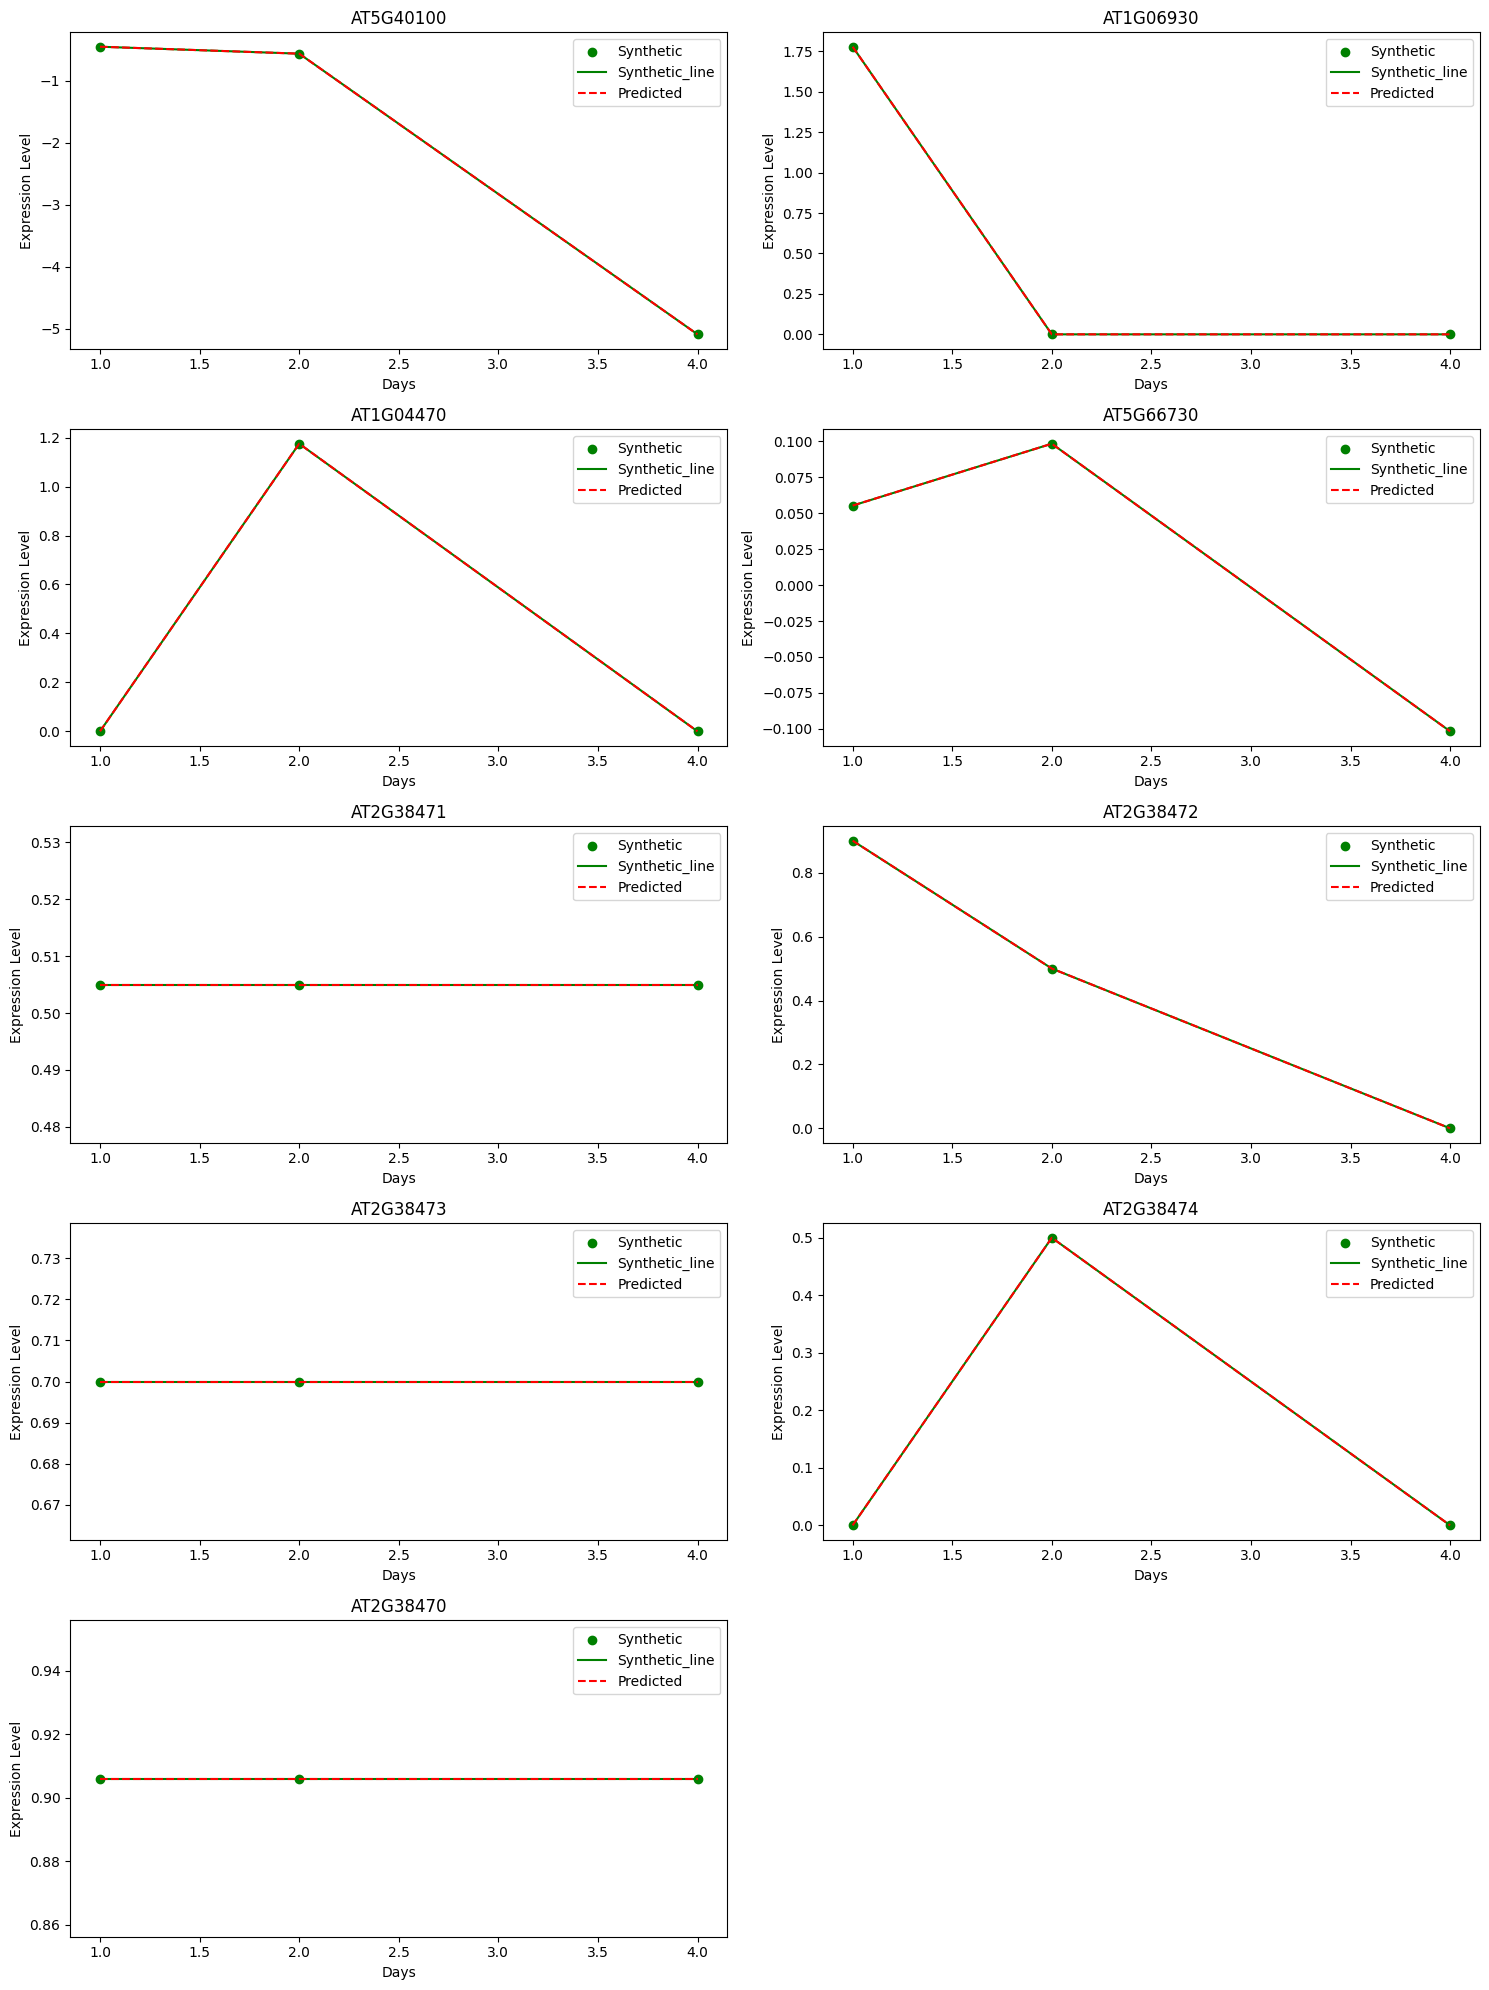

In [14]:
# Predict using the model
with torch.no_grad():
    preds_synthetic = model(time_points, initial_conditions).numpy().T

# Inverse normalization for synthetic data
synthetic_data_original = synthetic_data.T * (gene_max - gene_min) + gene_min
preds_synthetic_original = preds_synthetic * (gene_max - gene_min) + gene_min

# Plotting synthetic data and predictions
plt.figure(figsize=(15, 20))
for i, gene_id in enumerate(gene_ids):
    plt.subplot(5, 2, i+1)
    plt.scatter(time_points_np, synthetic_data_original[i], c='g', label='Synthetic')
    plt.plot(time_points_np, synthetic_data_original[i], c='g', label='Synthetic_line')
    plt.plot(time_points_np, preds_synthetic_original[i], 'r--', label='Predicted')
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression Level')
    plt.legend()
plt.tight_layout()
plt.show()

In [31]:
initial_conditions[:5]

tensor([1.0000, 1.0000, 0.0000, 0.7849, 0.0000])

In [3]:
# # Predict using the model
# with torch.no_grad():
#     preds_synthetic = model(time_points, initial_conditions[:5]).numpy().T

# # Inverse normalization for synthetic data
# synthetic_data_original = synthetic_data.T * (gene_max - gene_min) + gene_min
# preds_synthetic_original = preds_synthetic * (gene_max - gene_min) + gene_min

# # Plotting synthetic data and predictions
# plt.figure(figsize=(15, 20))
# for i, gene_id in enumerate(gene_ids):
#     plt.subplot(5, 2, i+1)
#     plt.scatter(time_points_np, synthetic_data_original[i], c='g', label='Synthetic')
#     plt.plot(time_points_np, synthetic_data_original[i], c='g', label='Synthetic_line')
#     plt.plot(time_points_np, preds_synthetic_original[i], 'r--', label='Predicted')
#     plt.title(gene_id)
#     plt.xlabel('Days')
#     plt.ylabel('Expression Level')
#     plt.legend()
# plt.tight_layout()
# plt.show()

Epoch    0 | Loss: 0.5748 (Data: 0.5748, Physics: 0.0000)
Epoch   50 | Loss: 0.0198 (Data: 0.0198, Physics: 0.0000)
Epoch  100 | Loss: 0.0006 (Data: 0.0006, Physics: 0.0000)
Epoch  150 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)
Epoch  200 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)
Epoch  250 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)


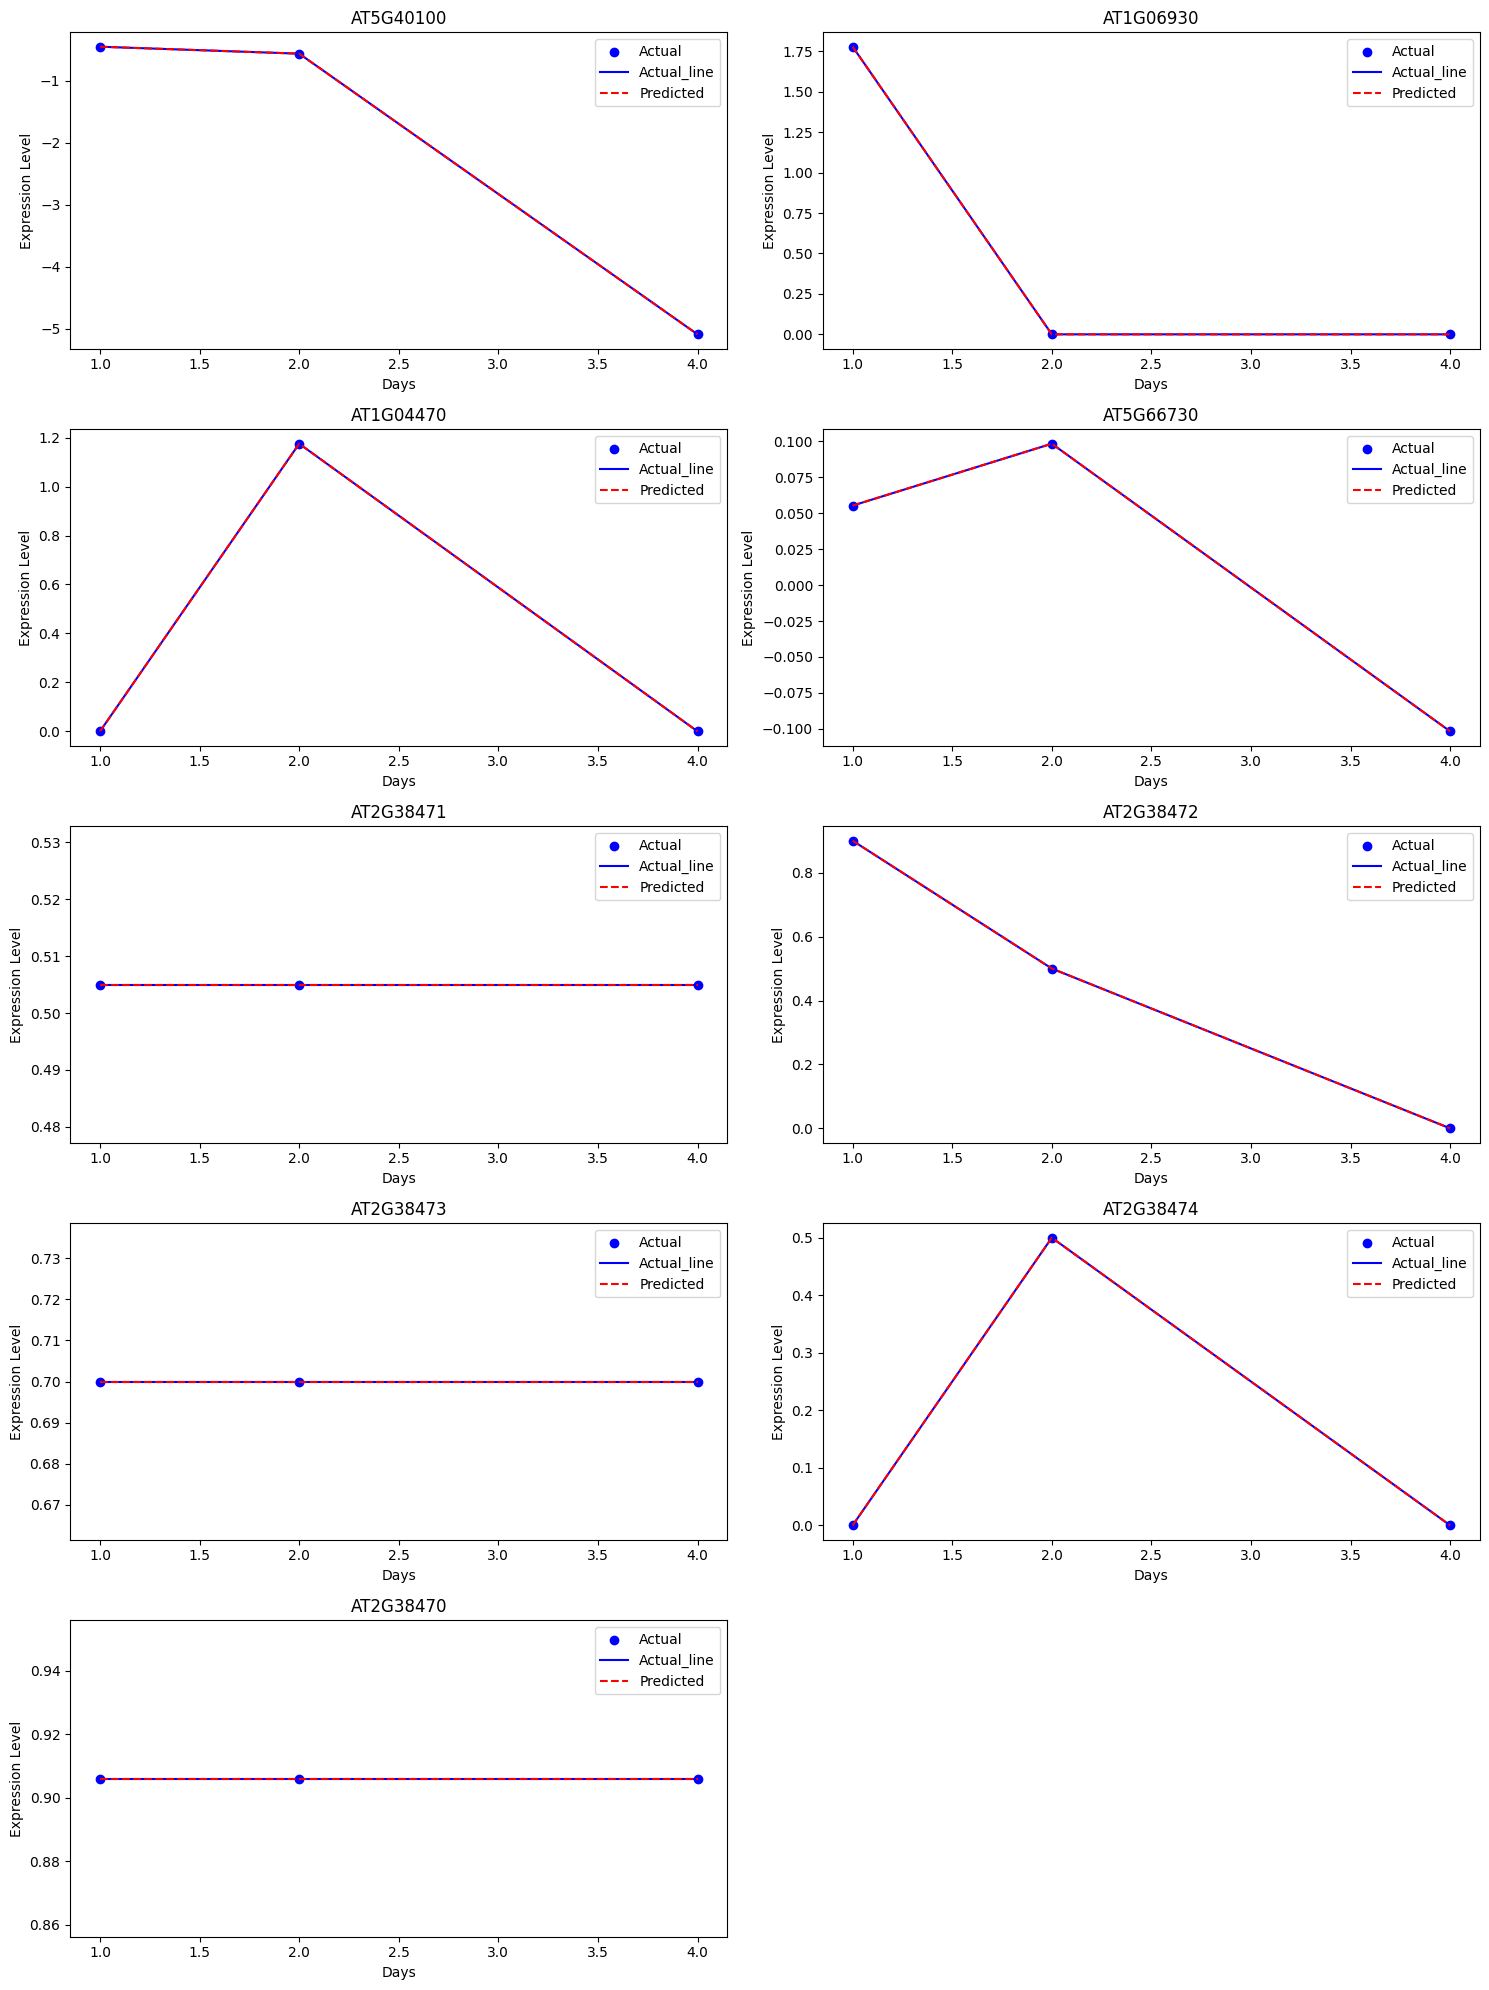


Learned ODE Parameters:
net.0.weight:
tensor([[-0.0262, -0.0032,  0.1088,  0.1761,  0.2325, -0.3021,  0.1646,  0.0787,
         -0.2990],
        [ 0.2643,  0.2225, -0.1580,  0.7037,  0.4362,  0.4849,  0.1701, -0.3313,
          0.2447],
        [-0.1803,  0.5044, -0.0547, -0.0304, -0.0874,  0.0365,  0.2008, -0.2348,
          0.3694],
        [-0.0527, -0.2953,  0.1872,  0.2062, -0.1427,  0.0706, -0.0626, -0.4164,
         -0.1559],
        [ 0.3560,  0.0579,  0.1414,  0.4185,  0.1315,  0.2157, -0.2052, -0.2137,
          0.3941],
        [-0.2016, -0.2201,  0.7753, -0.2256, -0.2971, -0.5525, -0.3247,  0.6407,
         -0.2253],
        [-0.3228, -0.3693,  0.2805, -0.3111,  0.0451, -0.5221, -0.0304, -0.1311,
          0.0071],
        [ 0.1531,  0.2725, -0.3155,  0.0952,  0.3563,  0.0703, -0.0851, -0.4291,
         -0.0937],
        [-0.4814, -0.0669,  0.5173, -0.6253, -0.2701, -0.5361, -0.0187,  0.3152,
         -0.2393],
        [ 0.0622, -0.0318, -0.3186, -0.2063,  0.2793,  0.2443

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # For ODE solving

# Load and preprocess data
df = pd.read_csv('arabido_example_genes (1).csv', index_col=0)
gene_ids = df.index.tolist()
time_points_np = np.array([1.0, 2.0, 4.0])
expression_data_np = df.values.astype(np.float32)

# Handle constant genes (prevent division by zero)
epsilon = 1e-8
gene_ranges = expression_data_np.max(axis=1) - expression_data_np.min(axis=1)
constant_genes = np.where(gene_ranges < epsilon)[0]
gene_ranges[constant_genes] = 1.0  # Avoid division by zero

# Normalization
gene_min = expression_data_np.min(axis=1, keepdims=True)
gene_max = expression_data_np.max(axis=1, keepdims=True)
normalized_data = (expression_data_np - gene_min) / (gene_max - gene_min + epsilon)

# Convert to tensors
time_points = torch.tensor(time_points_np, dtype=torch.float32)
normalized_tensor = torch.tensor(normalized_data, dtype=torch.float32)  # No transpose here

# Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self, n_genes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_genes, 16),
            nn.Tanh(),
            nn.Linear(16, n_genes)
        )
        self.n_genes = n_genes

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, t, y0):
        return odeint(self.odefunc, y0, t, method='dopri5')  # Use an ODE solver

# Initialize model
n_genes = len(gene_ids)
odefunc = ODEFunc(n_genes)
model = NeuralODEModel(odefunc)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 300
lambda_physics = 0.1

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Initial condition (normalized expression at t=0)
    y0 = normalized_tensor[:, 0]  # Use the first row as the initial condition

    # Forward pass (solve ODE)
    preds = model(time_points, y0)

    # Data loss (compare predictions with actual data)
    data_loss = torch.mean((preds - normalized_tensor.T) ** 2)  # Transpose for comparison

    physics_loss = 0
    for i in range(n_genes):
        if i not in constant_genes:
            # ***CHANGE***: Calculate dy_dt using the ODE function directly
            dy_dt = odefunc(time_points, preds)[:, i]

            # ***CHANGE***: Correctly calculate ode_rhs using the network
            ode_rhs = odefunc(time_points, preds)[:, i]  # Use the network's output directly

            physics_loss += torch.mean((dy_dt - ode_rhs.squeeze()) ** 2)

    total_loss = data_loss + lambda_physics * physics_loss
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch:4d} | Loss: {total_loss.item():.4f} '
              f'(Data: {data_loss.item():.4f}, Physics: {physics_loss.item():.4f})')

# Generate predictions
with torch.no_grad():
    y0 = normalized_tensor[:, 0]
    preds_normalized = model(time_points, y0).numpy().T

# Inverse normalization
preds_original = preds_normalized * (gene_max - gene_min) + gene_min

# Plotting
plt.figure(figsize=(15, 20))
for i, gene_id in enumerate(gene_ids):
    plt.subplot(5, 2, i+1)
    plt.scatter(time_points_np, expression_data_np[i], c='b', label='Actual')
    plt.plot(time_points_np, expression_data_np[i], c='b', label='Actual_line')
    plt.plot(time_points_np, preds_original[i], 'r--', label='Predicted')
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression Level')
    plt.legend()
plt.tight_layout()
plt.show()

# After training, print the ODE parameters
print("\nLearned ODE Parameters:")
for name, param in odefunc.named_parameters():
    if param.requires_grad:
        print(f"{name}:")
        print(param.data)

# Print ODE equations
print("\nODE Equations:")
for i, gene_id in enumerate(gene_ids):
    if i in constant_genes:
        print(f"\n{gene_id}: Constant expression (no ODE)")
        continue

    # Get the weights and bias for this gene
    weights = odefunc.net[2].weight[i].detach().numpy()
    bias = odefunc.net[2].bias[i].item()

    # Write the ODE equation
    equation = f"d{gene_id}/dt = "
    for j in range(n_genes):
        equation += f"{weights[j]:.4f}·{gene_ids[j]} + "
    equation += f"{bias:.4f}"
    print(f"\n{equation}")



In [6]:
initial_conditions

tensor([1.0000, 1.0000, 0.0000, 0.7849, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000])

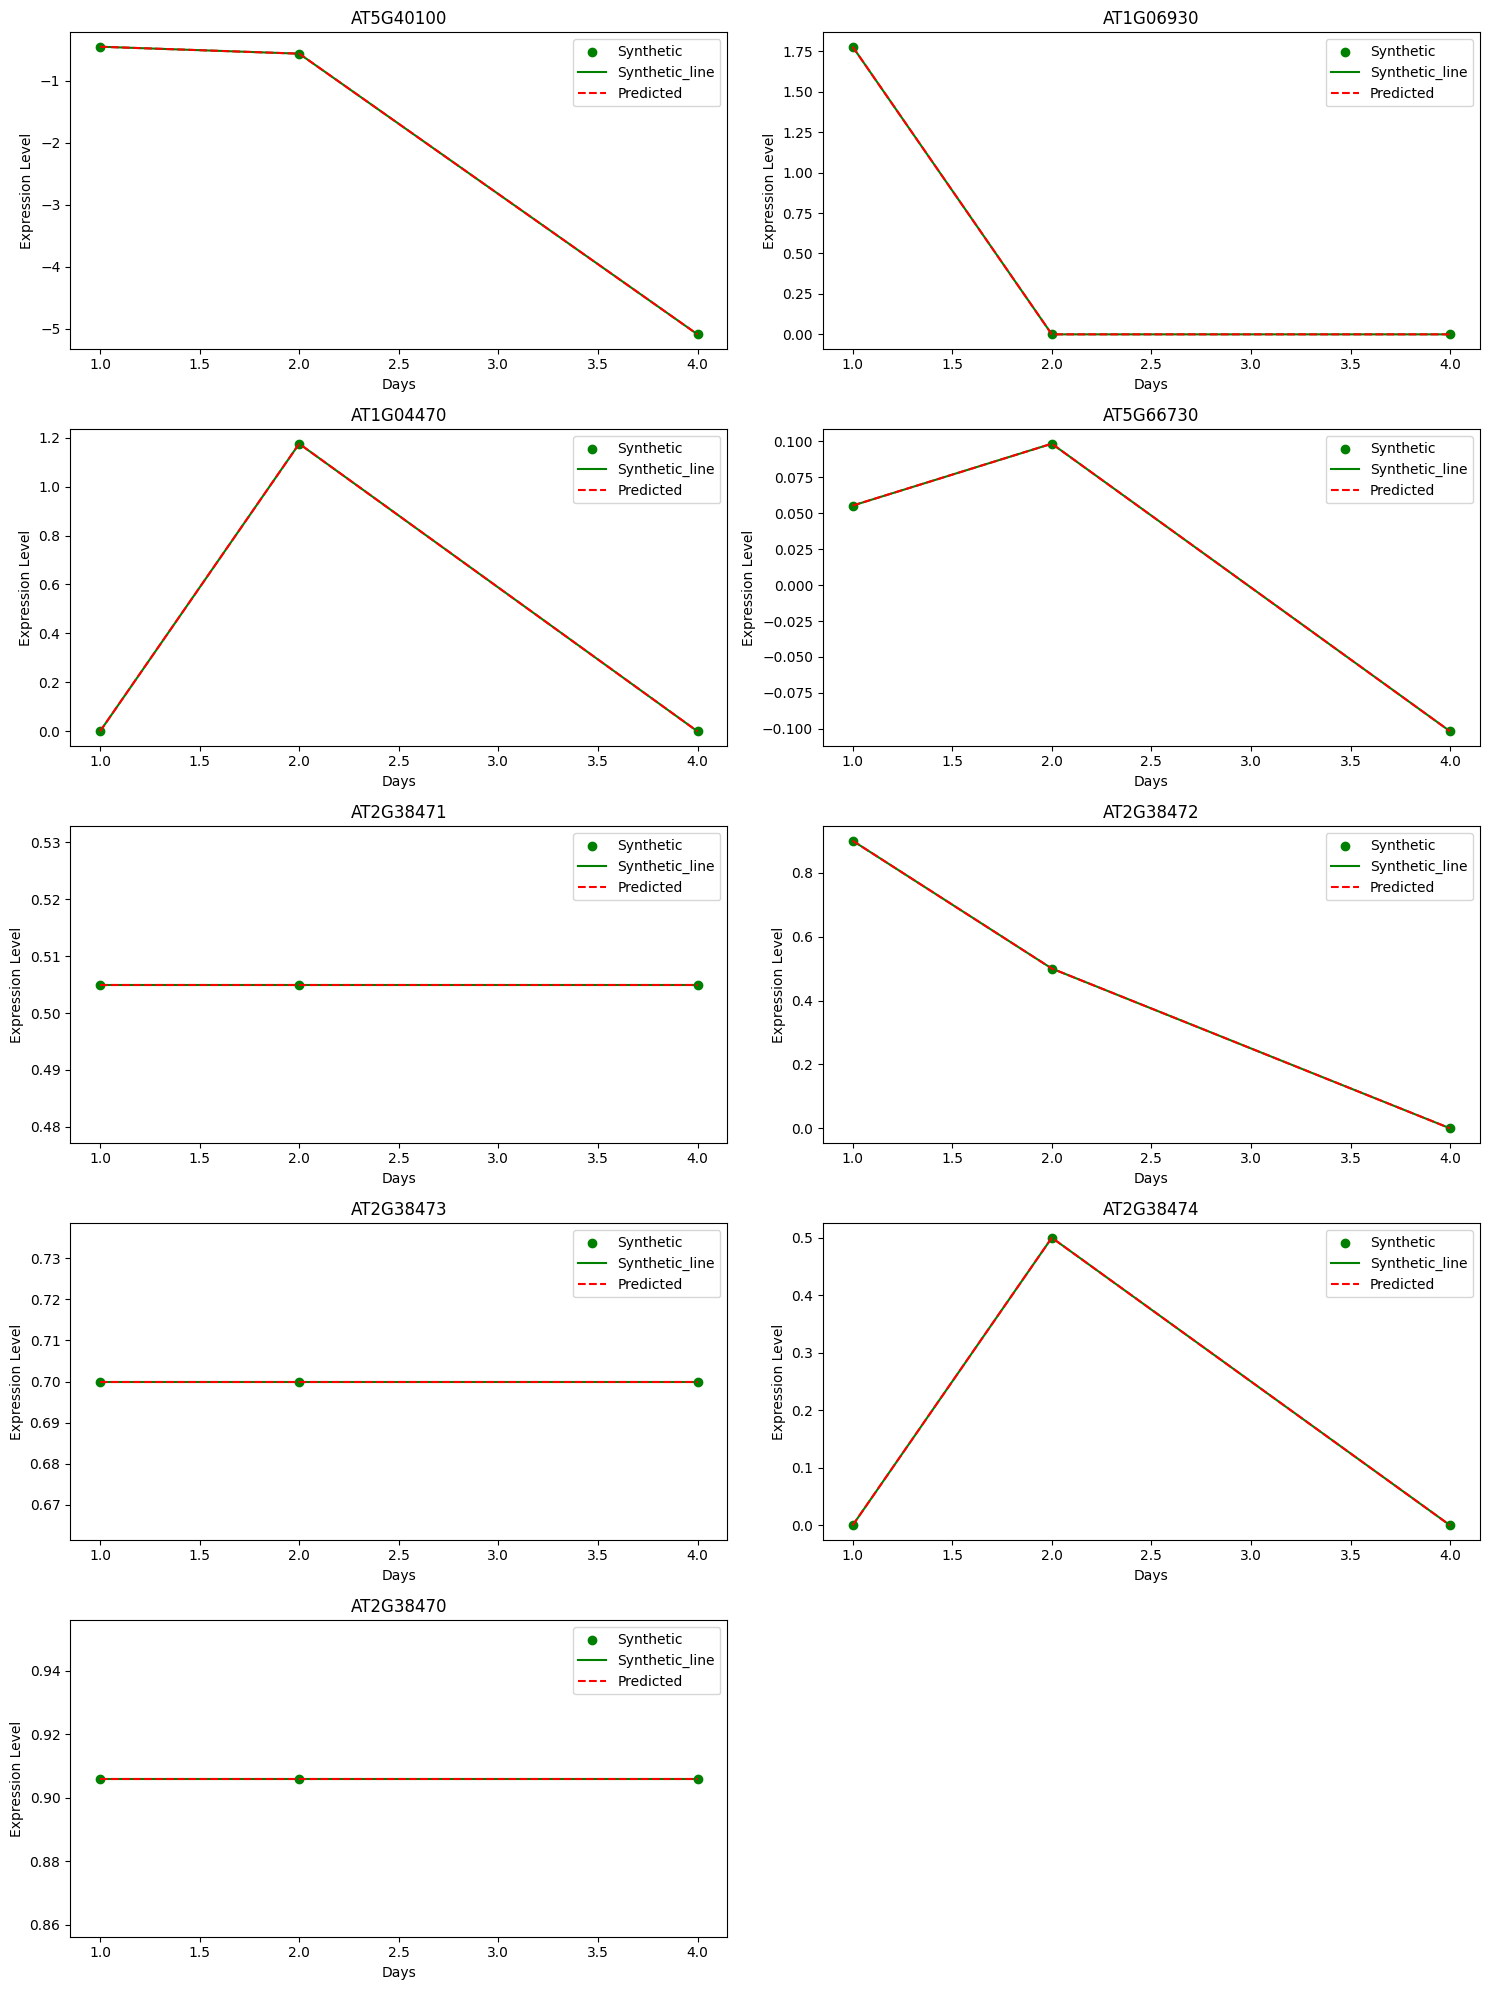

In [10]:
# Generate synthetic data using the learned ODEs
def generate_synthetic_data(odefunc, initial_conditions, time_points):
    with torch.no_grad():
        synthetic_data = odeint(odefunc, initial_conditions, time_points, method='dopri5') # This line was changed to use odeint
    return synthetic_data.numpy()

# Initial conditions for synthetic data generation
initial_conditions = torch.tensor(normalized_data[:, 0], dtype=torch.float32)

# Generate synthetic data
synthetic_data = generate_synthetic_data(odefunc, initial_conditions, time_points) # This line was changed to call generate_synthetic_data with the correct arguments

# ... (rest of the code)

# Predict using the model
with torch.no_grad():
    preds_synthetic = model(time_points, initial_conditions).numpy().T

# Inverse normalization for synthetic data
synthetic_data_original = synthetic_data.T * (gene_max - gene_min) + gene_min
preds_synthetic_original = preds_synthetic * (gene_max - gene_min) + gene_min

# Plotting synthetic data and predictions
plt.figure(figsize=(15, 20))
for i, gene_id in enumerate(gene_ids):
    plt.subplot(5, 2, i+1)
    plt.scatter(time_points_np, synthetic_data_original[i], c='g', label='Synthetic')
    plt.plot(time_points_np, synthetic_data_original[i], c='g', label='Synthetic_line')
    plt.plot(time_points_np, preds_synthetic_original[i], 'r--', label='Predicted')
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression Level')
    plt.legend()
plt.tight_layout()
plt.show()

In [11]:
initial_conditions

tensor([1.0000, 1.0000, 0.0000, 0.7849, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000])

In [12]:
synthetic_data

array([[ 1.0000000e+00,  1.0000000e+00,  0.0000000e+00,  7.8490454e-01,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 9.7584277e-01,  3.9905785e-07,  1.0000010e+00,  9.9999732e-01,
         5.4292673e-07,  5.5555725e-01, -3.4103232e-07,  9.9999946e-01,
        -5.0021401e-07],
       [ 2.8217818e-07, -5.9921240e-07,  6.2586844e-07, -1.2817367e-06,
        -1.6348342e-06, -1.3254570e-06, -1.9255569e-07,  2.5484479e-07,
        -6.8416654e-07]], dtype=float32)

Epoch    0 | Loss: 0.4301 (Data: 0.3621, Physics: 0.6797)
Epoch   50 | Loss: 0.1237 (Data: 0.0762, Physics: 0.4749)
Epoch  100 | Loss: 0.0029 (Data: 0.0025, Physics: 0.0036)
Epoch  150 | Loss: 0.0001 (Data: 0.0001, Physics: 0.0002)
Epoch  200 | Loss: 0.0000 (Data: 0.0000, Physics: 0.0000)
Epoch  250 | Loss: 0.0002 (Data: 0.0001, Physics: 0.0012)


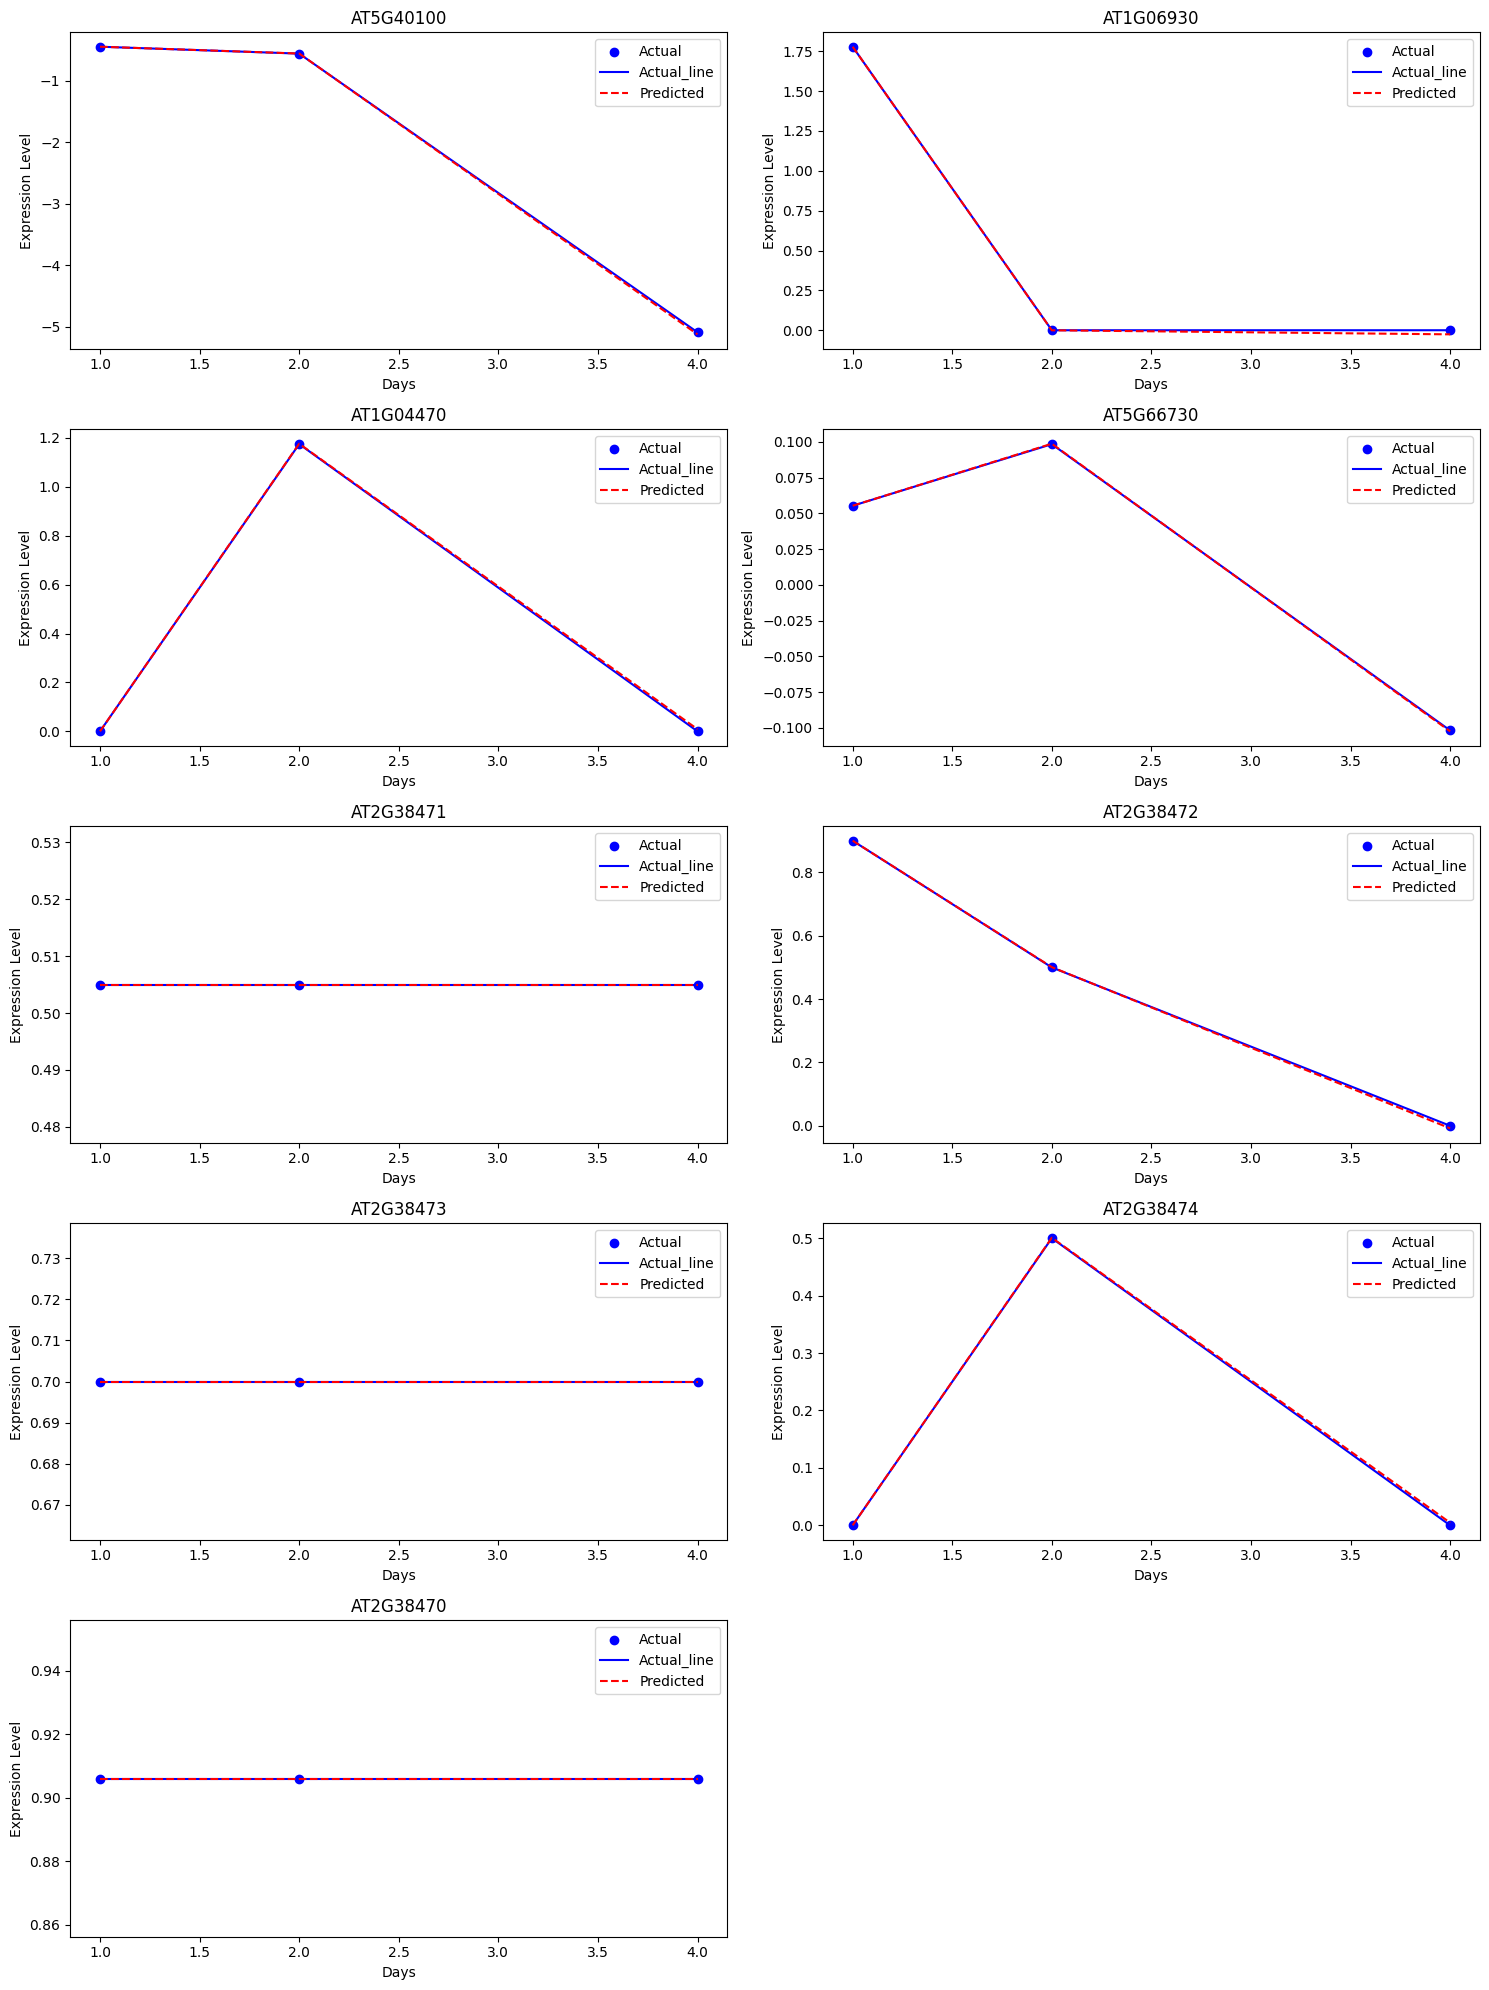


Learned ODE Parameters:
net.0.weight:
tensor([[-2.0684e-01, -1.3138e-01, -2.4854e-01, -1.8119e-01,  1.2780e-01,
         -4.8290e-02,  1.6782e-01, -4.3532e-01,  2.3145e-01],
        [ 1.2146e-01, -1.5462e-01, -2.6846e-01, -2.2021e-01,  2.6985e-01,
         -1.0557e-01, -1.4351e-01,  3.3312e-02,  4.0530e-01],
        [ 1.7960e-01, -1.6932e-01, -4.4375e-01, -4.2694e-01,  5.9000e-01,
          8.9398e-02,  5.2096e-01, -8.6361e-01,  3.8122e-03],
        [-2.2447e-01, -1.1547e-01, -2.8963e-01, -1.4170e-01,  3.4455e-01,
         -3.3330e-01,  4.2044e-01, -1.9928e-01, -9.4440e-02],
        [-2.1006e-02, -8.2703e-03, -1.1512e-01, -2.5895e-01,  7.0182e-01,
          1.4545e-01,  5.1795e-01, -1.0674e-01, -6.4607e-01],
        [-1.3881e-01, -5.3681e-02,  2.9729e-01, -2.4039e-01,  4.0020e-02,
         -5.3982e-01,  5.0641e-01,  5.5774e-02,  4.3415e-01],
        [ 1.9704e-01, -2.9686e-02,  2.3237e-01,  1.3204e-01, -2.7844e-01,
          1.4301e-01, -6.3563e-03,  2.8726e-01, -3.2988e-01],
        [

In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # For ODE solving

# Load and preprocess data
df = pd.read_csv('arabido_example_genes (1).csv', index_col=0)
gene_ids = df.index.tolist()
time_points_np = np.array([1.0, 2.0, 4.0])
expression_data_np = df.values.astype(np.float32)

# Handle constant genes (prevent division by zero)
epsilon = 1e-8
gene_ranges = expression_data_np.max(axis=1) - expression_data_np.min(axis=1)
constant_genes = np.where(gene_ranges < epsilon)[0]
gene_ranges[constant_genes] = 1.0  # Avoid division by zero

# Normalization
gene_min = expression_data_np.min(axis=1, keepdims=True)
gene_max = expression_data_np.max(axis=1, keepdims=True)
normalized_data = (expression_data_np - gene_min) / (gene_max - gene_min + epsilon)

# Convert to tensors
time_points = torch.tensor(time_points_np, dtype=torch.float32, requires_grad=True) # Add requires_grad=True
normalized_tensor = torch.tensor(normalized_data.T, dtype=torch.float32)  # Transpose here

# Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self, n_genes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_genes, 16),
            nn.Tanh(),
            nn.Linear(16, n_genes)
        )
        self.n_genes = n_genes

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, t, y0):
        return odeint(self.odefunc, y0, t, method='dopri5')  # Use an ODE solver

# Initialize model
n_genes = len(gene_ids)
odefunc = ODEFunc(n_genes)
model = NeuralODEModel(odefunc)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 300
lambda_physics = 0.1

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Initial condition (normalized expression at t=0)
    y0 = normalized_tensor[0]  # Use the first row as the initial condition

    # Forward pass (solve ODE)
    preds = model(time_points, y0)

    # Data loss (compare predictions with actual data)
    data_loss = torch.mean((preds - normalized_tensor) ** 2)  # No transpose needed

    physics_loss = 0
    for i in range(n_genes):
        if i not in constant_genes:
            # Compute the derivative from the ODE function
            dy_dt = torch.autograd.grad(
                # outputs=preds,
                outputs=preds[:, i],
                inputs=time_points,
                grad_outputs=torch.ones_like(preds[:, i]),
                create_graph=True,
                retain_graph=True
            )[0]

            # Correctly calculate ode_rhs using the network
            ode_rhs = odefunc(time_points, preds)[:, i]

            physics_loss += torch.mean((dy_dt - ode_rhs) ** 2)

    total_loss = data_loss + lambda_physics * physics_loss
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch:4d} | Loss: {total_loss.item():.4f} '
              f'(Data: {data_loss.item():.4f}, Physics: {physics_loss.item():.4f})')

# Generate predictions
with torch.no_grad():
    y0 = normalized_tensor[0]
    preds_normalized = model(time_points, y0).numpy()

# Inverse normalization
preds_original = preds_normalized * (gene_max - gene_min).T + gene_min.T

# Plotting
plt.figure(figsize=(15, 20))
for i, gene_id in enumerate(gene_ids):
    plt.subplot(5, 2, i+1)
    plt.scatter(time_points_np, expression_data_np[i], c='b', label='Actual')
    plt.plot(time_points_np, expression_data_np[i], c='b', label='Actual_line')
    plt.plot(time_points_np, preds_original[:, i], 'r--', label='Predicted')
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression Level')
    plt.legend()
plt.tight_layout()
plt.show()

# After training, print the ODE parameters
print("\nLearned ODE Parameters:")
for name, param in odefunc.named_parameters():
    if param.requires_grad:
        print(f"{name}:")
        print(param.data)

# Print ODE equations
print("\nODE Equations:")
for i, gene_id in enumerate(gene_ids):
    if i in constant_genes:
        print(f"\n{gene_id}: Constant expression (no ODE)")
        continue

    # Get the weights and bias for this gene
    weights = odefunc.net[2].weight[i].detach().numpy()
    bias = odefunc.net[2].bias[i].item()

    # Write the ODE equation
    equation = f"d{gene_id}/dt = "
    for j in range(n_genes):
        equation += f"{weights[j]:.4f}·{gene_ids[j]} + "
    equation += f"{bias:.4f}"
    print(f"\n{equation}")



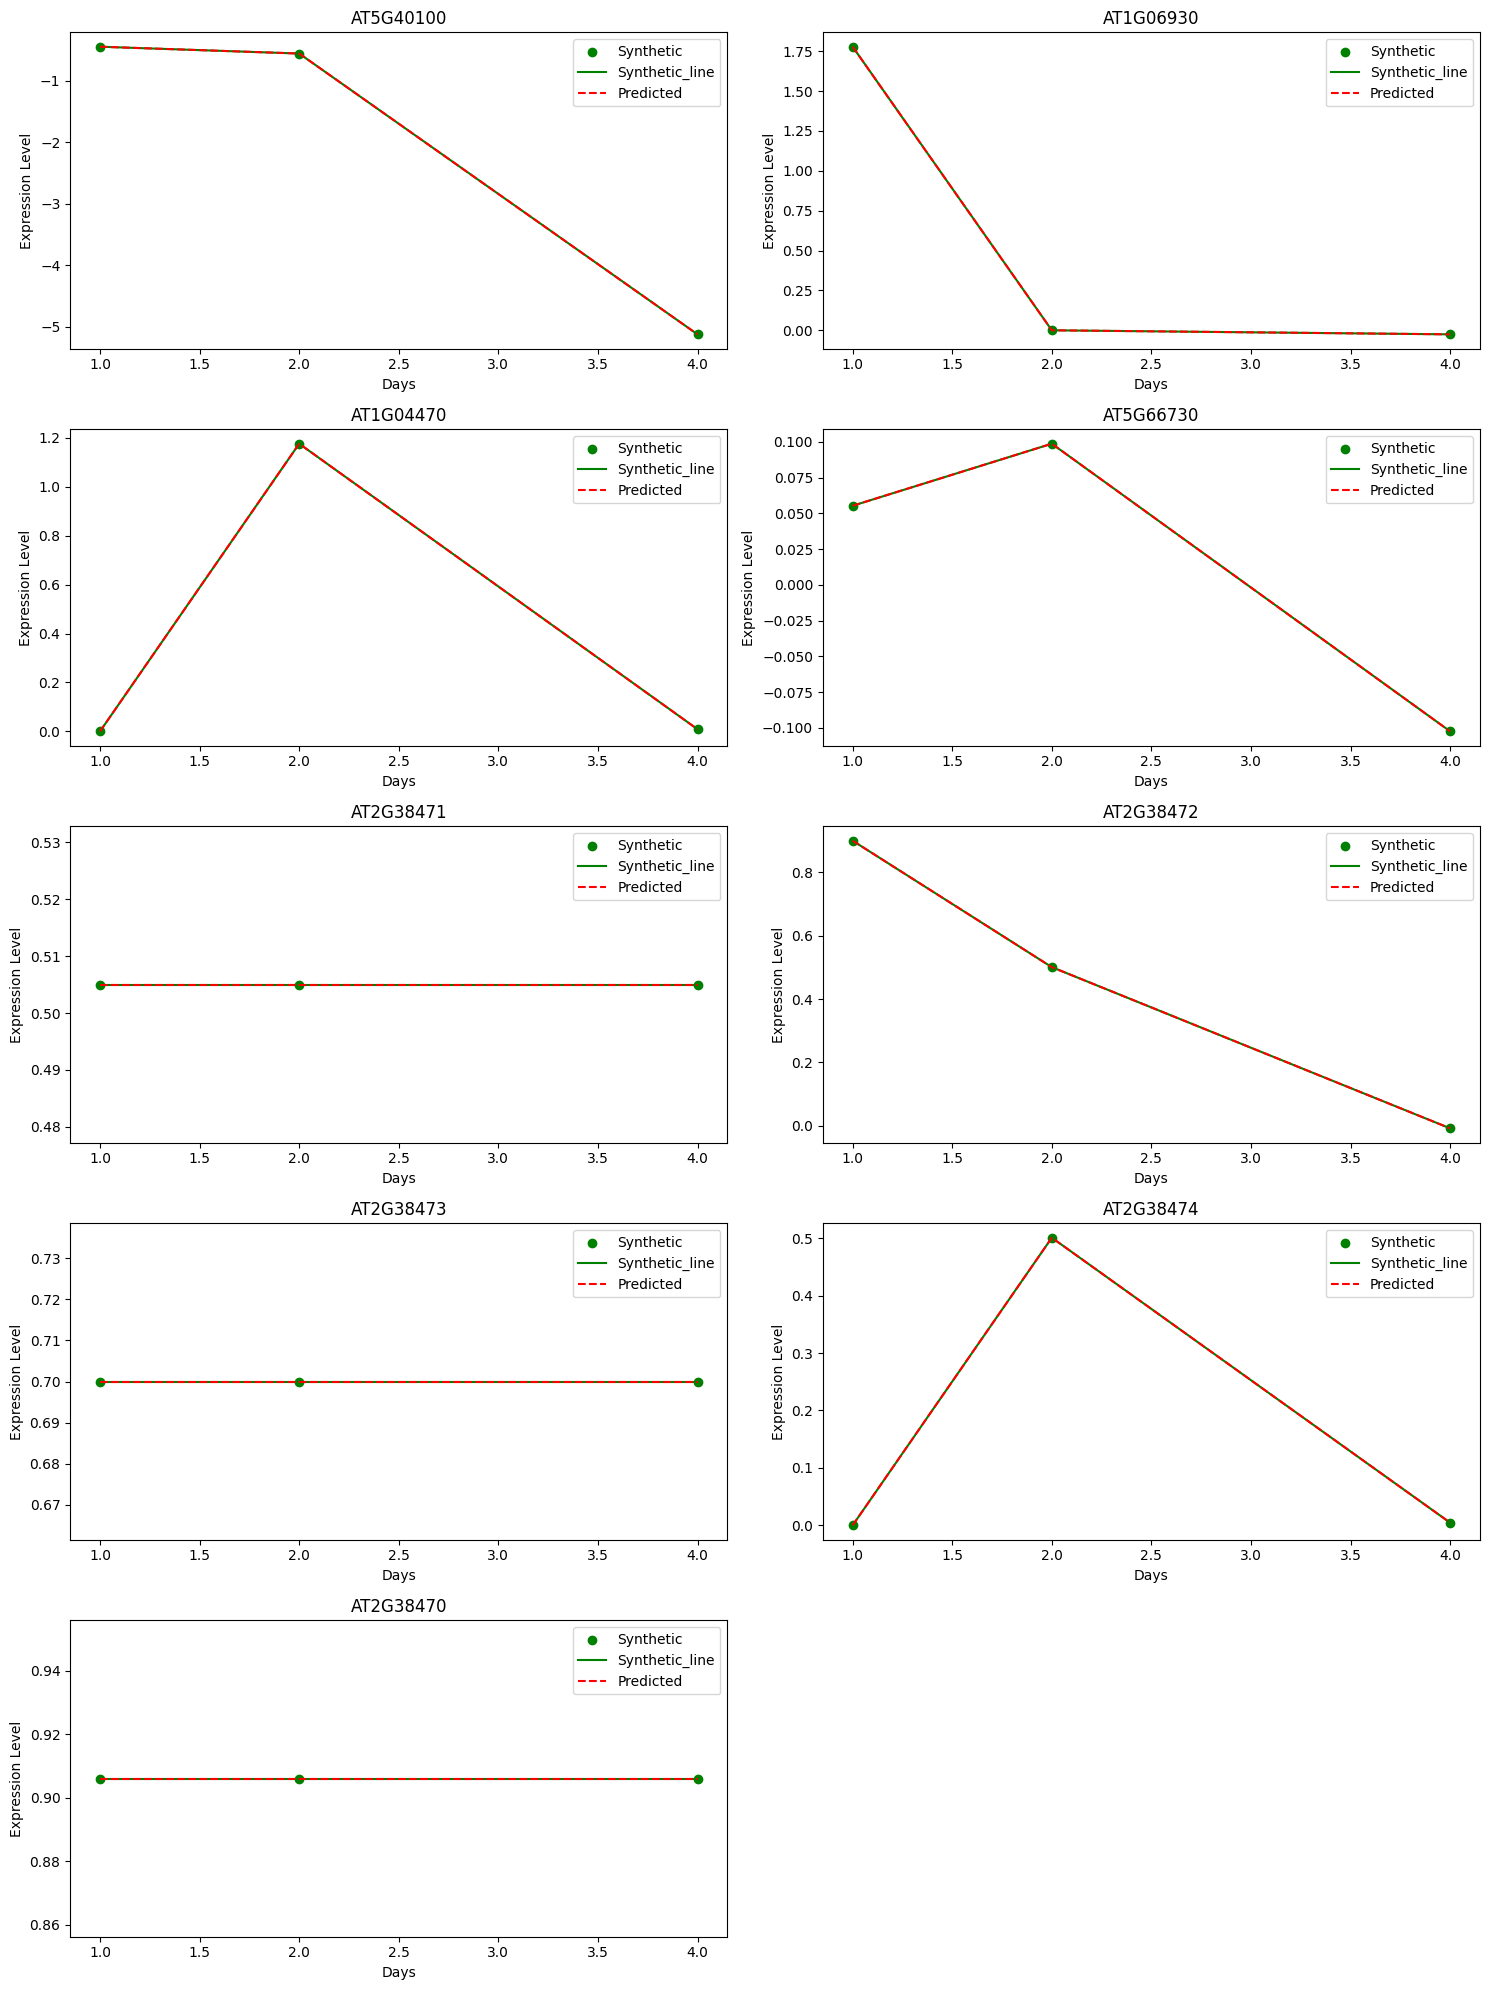

In [30]:
# Generate synthetic data using the learned ODEs
def generate_synthetic_data(odefunc, initial_conditions, time_points):
    with torch.no_grad():
        #***CHANGE***: Remove unsqueeze to keep initial_conditions shape (9,)
        #initial_conditions = initial_conditions.unsqueeze(0)  # Add batch dimension

        synthetic_data = odeint(odefunc, initial_conditions, time_points, method='dopri5')
    return synthetic_data.numpy()

# Initial conditions for synthetic data generation
#***CHANGE***: Use normalized_data[:, 0] to get initial conditions for all genes
initial_conditions = torch.tensor(normalized_data[:, 0], dtype=torch.float32)

# Generate synthetic data
synthetic_data = generate_synthetic_data(odefunc, initial_conditions, time_points)

# Predict using the model
with torch.no_grad():
    #***CHANGE***: Remove unsqueeze to keep initial_conditions shape (9,)
    #initial_conditions = initial_conditions.unsqueeze(0)  # Add batch dimension
    preds_synthetic = model(time_points, initial_conditions).numpy()



# Inverse normalization for synthetic data
synthetic_data_original = synthetic_data * (gene_max - gene_min + epsilon).T + gene_min.T  # Transpose for broadcasting
preds_synthetic_original = preds_synthetic * (gene_max - gene_min + epsilon).T + gene_min.T  # Transpose for broadcasting



# Plotting synthetic data and predictions
plt.figure(figsize=(15, 20))
for i, gene_id in enumerate(gene_ids):
    plt.subplot(5, 2, i+1)
    #***CHANGE***: Use synthetic_data_original[:, i] for y values
    plt.scatter(time_points_np, synthetic_data_original[:, i], c='g', label='Synthetic')
    plt.plot(time_points_np, synthetic_data_original[:, i], c='g', label='Synthetic_line')
    plt.plot(time_points_np, preds_synthetic_original[:, i], 'r--', label='Predicted') #***CHANGE***: Use preds_synthetic_original[:, i] for predictions
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression Level')
    plt.legend()
plt.tight_layout()
plt.show()

In [24]:
time_points

tensor([1., 2., 4.], requires_grad=True)

In [25]:
odefunc

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=9, bias=True)
  )
)